### ANOVA (TYPE I II III)
```
ANOVA分析基本上在分析是否各群組間變異數是否一樣
H0: 各個群組變異數都相等
H1: 存在一組一上變異數跟其他組不同
但是ANOVA其實還有一堆分別 [Type-I、Type-II、Type-III], 這邊已經確定不需要去了解他, 只要知道anova目的是分析是否各群組間變異數是否一樣就好了

[one-way、two-way、n-way] 其實就是看多個群體間, model是看幾個factor(s)影響了群體, 例如: 看工時是否影響兩個群體間生產率的多少, 工時就是一個factor
```
- [B E L L E A Y A 雜七雜八創作小窩-參考這篇講解頗清楚](http://belleaya.pixnet.net/blog/post/30754486-%5B%E6%95%99%E5%AD%B8%5D-%5B%E7%B5%B1%E8%A8%88%5D-anova%E8%AE%8A%E7%95%B0%E6%95%B8%E5%88%86%E6%9E%90-%E5%B0%8F%E7%AD%86%E8%A8%98)
- [其他參考連結1](http://www.statisticssolutions.com/manova-analysis-anova/) 有講何時用TypeI or TypeII or TypeIII
- [其他參考連結2](https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/)

```
迴歸有fvalue, ANOVA也有fvalue, 兩個的算法看起來像卻又不一樣...
- anova的是 MSB/MSW 組間變異/組內變異 (B E L L E A Y A那個連結有詳細公式)
- 迴歸的是 MSR/MSE 迴歸變異/誤差變異, ptt竟然有人說他是一樣(https://www.ptt.cc/bbs/TransPSY/M.1290775621.A.FDC.html)
statsmodels的anova分析的target都是對於迴歸的result => http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/interactions_anova.html
定義跟用法都串不起來, 迴歸只有一組資料, anova是要探討多組資料, 結果statsmodels範例都是帶迴歸結果進去, 請問"多群組"是哪裡來?

=> 去爬個code之後, 發現他的組間變異(SSB)是探討每個自變數和model的關係, SSB的算法請看(note1), SSW是就是迴歸結果的 MSE = SSE / 自由度(df_total - df_model), 如果回歸式 Y = intercept + A0X0 + A1X1 + A2X2, 那就會有3組fvalue(X0, X1, X2)
```
```python
## note1: Y = AX(線性關係以矩陣表達為Y = AX), A作QR分解, Q是正交矩陣, 
A = qr
effects = np.dot(q.T, Y), 
SSB = (effects**2 / {各自變數自由度}) # 連續變數通常自由度是1, 離散變數拆成dummy變數以binary方式表示自由度才有可能 > 2
# 看了上面的實作再看看定義, 個人實在無法串起來, 你組間變異數可以變形成這樣, QR分解後的Q transpose去跟Y作外積???
```

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
from __future__ import division, unicode_literals, with_statement, print_function
from contextlib import closing

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys
os.environ['HTTP_PROXY'] = 'http://fwgate:8080'
os.environ['HTTPS_PROXY'] = 'https://fwgate:8080'

In [3]:
from statsmodels.formula.api import ols

moore = sm.datasets.get_rdataset("Moore", "car", cache=True) # load data
data = moore.data
data = data.rename(columns={"partner.status" : "partner_status"}) # make name pythonic
data

,partner_status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36
5,low,6,low,18
6,low,12,medium,51
7,low,4,medium,44
8,low,13,low,31
9,low,12,low,36


In [4]:
moore_lm = ols('conformity ~ C(fcategory, Sum)*C(partner_status, Sum)', data=data).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 ANOVA DataFrame

print(table)

                                              sum_sq  df          F    PR(>F)
C(fcategory, Sum)                          11.614700   2   0.276958  0.759564
C(partner_status, Sum)                    212.213778   1  10.120692  0.002874
C(fcategory, Sum):C(partner_status, Sum)  175.488928   2   4.184623  0.022572
Residual                                  817.763961  39        NaN       NaN


In [5]:
moore_lm.model.loglike(moore_lm.params)

-129.10023709682258

In [6]:
# conformity ~ C(fcategory, Sum)*C(partner_status, Sum)背後的迴歸式
moore_lm.model.data.orig_exog

,Intercept,"C(fcategory, Sum)[S.high]","C(fcategory, Sum)[S.low]","C(partner_status, Sum)[S.high]","C(fcategory, Sum)[S.high]:C(partner_status, Sum)[S.high]","C(fcategory, Sum)[S.low]:C(partner_status, Sum)[S.high]"
0,1,0,1,-1,-0,-1
1,1,1,0,-1,-1,-0
2,1,1,0,-1,-1,-0
3,1,0,1,-1,-0,-1
4,1,0,1,-1,-0,-1
5,1,0,1,-1,-0,-1
6,1,-1,-1,-1,1,1
7,1,-1,-1,-1,1,1
8,1,0,1,-1,-0,-1
9,1,0,1,-1,-0,-1


### 薪水資料的範例
```python

```

In [7]:
from __future__ import print_function
from statsmodels.compat import urlopen
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import statsmodels.api as sm
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

try:
    salary_table = pd.read_csv('salary.table')
except:  # recent pandas can read URL without urlopen
    url = 'http://stats191.stanford.edu/data/salary.table'
    fh = urlopen(url)
    salary_table = pd.read_table(fh)
    salary_table.to_csv('salary.table')

E = salary_table.E # education, 教育程度
M = salary_table.M # management, 是否有管理職
X = salary_table.X # 經驗
S = salary_table.S # 薪水

In [8]:
salary_table

,Unnamed: 0,S,X,E,M
0,0,13876,1,1,1
1,1,11608,1,3,0
2,2,18701,1,3,1
3,3,11283,1,2,0
4,4,11767,1,3,0
5,5,20872,2,2,1
6,6,11772,2,2,0
7,7,10535,2,1,0
8,8,12195,2,3,0
9,9,12313,3,2,0


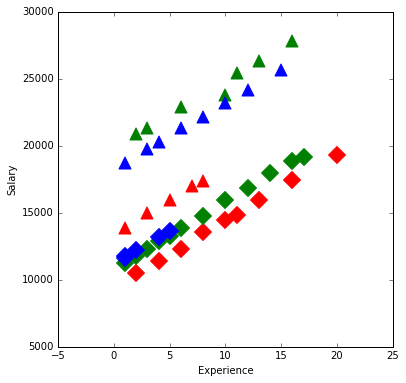

In [9]:
# preview data
plt.figure(figsize=(6,6))
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
factor_groups = salary_table.groupby(['E','M'])
for values, group in factor_groups:
    i,j = values
    plt.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1],
               s=144)
plt.xlabel('Experience')
plt.ylabel('Salary')

In [10]:
# C() 的意思式強制把該變數看作類別變數(即使他是 integer)
formula = 'S ~ C(E) + C(M) + X'
lm = ols(formula, salary_table).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Fri, 30 Sep 2016   Prob (F-statistic):           2.23e-27
Time:                        10:08:26   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

In [123]:
# y = AX, Y: lm.model.endog, A: lm.model.exog, X: lm.params

In [119]:
# 'S ~ C(E) + C(M) + X'
from statsmodels.formula.formulatools import (_remove_intercept_patsy, _has_intercept, _intercept_idx)
design_info = lm.model.data.orig_exog.design_info
effects = None
n_rows = len(design_info.terms) - (INTERCEPT in design_info.terms) + 1
q, r = np.linalg.qr(lm.model.exog)
q, r
print(q.shape, r.shape)
effects = np.dot(q.T, lm.model.endog)
print(effects)

slices = [design_info.slice(name) for name in design_info.term_names]
arr = np.zeros((len(design_info.terms), len(design_info.column_names)))
for i, slice_ in enumerate(slices):
    arr[i, slice_] = 1
print(arr)

sum_sq = np.dot(arr, effects**2)
idx = _intercept_idx(design_info)
sum_sq = sum_sq[~idx]
np.c_[arr[~idx].sum(1), sum_sq]
(sum_sq/arr[~idx].sum(1))/(lm.ssr/lm.df_resid)

(46L, 5L) (5L, 5L)
[-117132.1658    5781.5114   -8701.0788   22596.1123   18387.4392]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


array([  51.6918,  483.6786,  320.2815])

In [67]:
effects = getattr(lm, 'effects', None)
print(effects)

None


In [70]:
anova_lm(lm, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(E),2,1.091346e+08,5.456732e+07,51.691845,6.193659e-12
C(M),1,5.105843e+08,5.105843e+08,483.678556,2.594015e-24
X,1,3.380979e+08,3.380979e+08,320.281524,5.546313e-21
Residual,41,4.328072e+07,1.055627e+06,NaN,NaN


In [32]:
anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(E),9.152624e+07,2,43.351589,7.672450e-11
C(M),5.075724e+08,1,480.825394,2.901444e-24
X,3.380979e+08,1,320.281524,5.546313e-21
Residual,4.328072e+07,41,NaN,NaN


In [27]:
anova_lm(lm, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,4.558508e+08,1,431.829336,2.199232e-23
C(E),9.152624e+07,2,43.351589,7.672450e-11
C(M),5.075724e+08,1,480.825394,2.901444e-24
X,3.380979e+08,1,320.281524,5.546313e-21
Residual,4.328072e+07,41,NaN,NaN


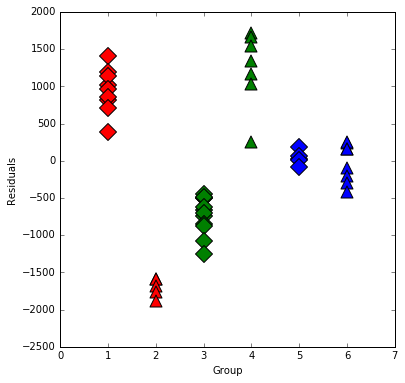

In [9]:
resid = lm.resid
plt.figure(figsize=(6,6));
for values, group in factor_groups:
    i,j = values
    group_num = i*2 + j - 1  # for plotting purposes
    x = [group_num] * len(group)
    plt.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Residuals');

In [15]:
interX_lm = ols("S ~ C(E) * X + C(M)", salary_table).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Fri, 30 Sep 2016   Prob (F-statistic):           8.23e-26
Time:                        10:17:15   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

In [16]:
from statsmodels.stats.api import anova_lm

table1 = anova_lm(lm, interX_lm)
print(table1)

interM_lm = ols("S ~ X + C(E)*C(M)", data=salary_table).fit()
print(interM_lm.summary())

table2 = anova_lm(lm, interM_lm)
print(table2)

   df_resid              ssr  df_diff         ss_diff         F    Pr(>F)
0        41  43280719.492876        0             NaN       NaN       NaN
1        39  39410679.807560        2  3870039.685316  1.914856  0.160964
                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Fri, 30 Sep 2016   Prob (F-statistic):           1.67e-55
Time:                        10:17:19   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                              

In [17]:
interM_lm.model.data.orig_exog[:5]

,Intercept,C(E)[T.2],C(E)[T.3],C(M)[T.1],C(E)[T.2]:C(M)[T.1],C(E)[T.3]:C(M)[T.1],X
0,1,0,0,1,0,0,1
1,1,0,1,0,0,0,1
2,1,0,1,1,0,1,1
3,1,1,0,0,0,0,1
4,1,0,1,0,0,0,1


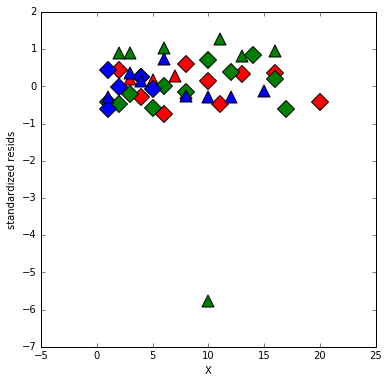

In [18]:
# 看標準殘差有個outlier
infl = interM_lm.get_influence()
resid = infl.resid_studentized_internal
plt.figure(figsize=(6,6))
for values, group in factor_groups:
    i,j = values
    idx = group.index
    plt.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
plt.xlabel('X');
plt.ylabel('standardized resids');

In [26]:
print(anova_lm(lm, interX_lm))
print(anova_lm(lm, interM_lm))

   df_resid              ssr  df_diff         ss_diff         F    Pr(>F)
0        41  43280719.492876        0             NaN       NaN       NaN
1        39  39410679.807560        2  3870039.685316  1.914856  0.160964
   df_resid              ssr  df_diff          ss_diff           F        Pr(>F)
0        41  43280719.492876        0              NaN         NaN           NaN
1        39   1178167.864864        2  42102551.628012  696.844466  3.025504e-31


In [39]:
# 拿掉outlier, 重新再來一次
drop_idx = abs(resid).argmax()
print(drop_idx)  # zero-based index
idx = salary_table.index.drop(drop_idx)

lm32 = ols('S ~ C(E) + X + C(M)', data=salary_table, subset=idx).fit()
print('lm32')
print(lm32.summary())
print('\n')

interX_lm32 = ols('S ~ C(E) * X + C(M)', data=salary_table, subset=idx).fit()

print('interX_lm32')
print(interX_lm32.summary())
print('\n')

print('interM_lm32')
print(interM_lm32.summary())
print('\n')


table3 = anova_lm(lm32, interX_lm32)
print(table3)
print('\n')


interM_lm32 = ols('S ~ X + C(E) * C(M)', data=salary_table, subset=idx).fit()

table4 = anova_lm(lm32, interM_lm32)
print(table4)
print('\n')

32
lm32
                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     211.7
Date:                Fri, 30 Sep 2016   Prob (F-statistic):           2.45e-26
Time:                        10:35:26   Log-Likelihood:                -373.79
No. Observations:                  45   AIC:                             757.6
Df Residuals:                      40   BIC:                             766.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8044.7518    392.781     20.482 

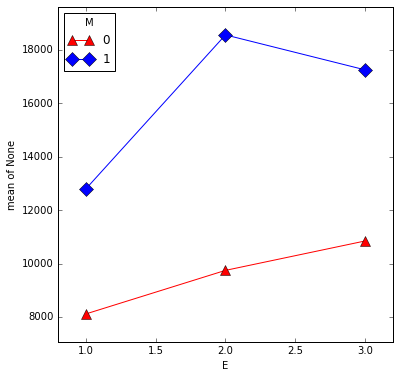

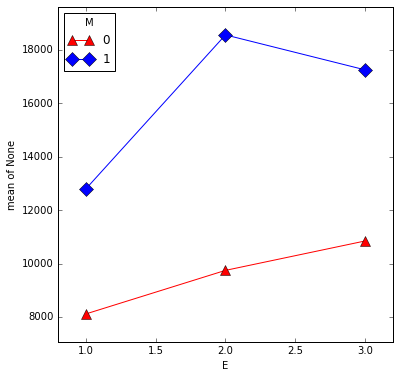

In [51]:
# U 是扣掉經驗的後的data (竟然可以這樣扣除?)
U = S - X * interX_lm32.params['X']
plt.figure(figsize=(6,6))
interaction_plot(E, M, U, colors=['red','blue'], markers=['^','D'], markersize=10, ax=plt.gca())

In [52]:
try:
    kidney_table = pd.read_table('./kidney.table')
except:
    url = 'http://stats191.stanford.edu/data/kidney.table'
    kidney_table = pd.read_table(url, delimiter=" *")

D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


In [53]:
kidney_table

,Days,Duration,Weight,ID
0,0,1,1,1
1,2,1,1,2
2,1,1,1,3
3,3,1,1,4
4,0,1,1,5
5,2,1,1,6
6,0,1,1,7
7,5,1,1,8
8,6,1,1,9
9,8,1,1,10


### Sum of squares
```
Illustrates the use of different types of sums of squares (I,II,II) and how the Sum contrast can be used to produce the same output between the 3.
Types I and II are equivalent under a balanced design.
Don't use Type III with non-orthogonal contrast - ie., Treatment

上面是官網描述, type i, ii, iii 的anova分析
```

In [61]:

kt = kidney_table
sum_lm = ols('np.log(Days+1) ~ C(Duration, Treatment) * C(Weight, Treatment)', data=kt).fit()

print(anova_lm(sum_lm))
print(anova_lm(sum_lm, typ=2))
print(anova_lm(sum_lm, typ=3))


                                             df     sum_sq   mean_sq          F    PR(>F)
C(Duration, Treatment)                        1   2.339693  2.339693   4.358293  0.041562
C(Weight, Treatment)                          2  16.971291  8.485645  15.806745  0.000004
C(Duration, Treatment):C(Weight, Treatment)   2   0.635658  0.317829   0.592040  0.556748
Residual                                     54  28.989198  0.536837        NaN       NaN
                                                sum_sq  df          F    PR(>F)
C(Duration, Treatment)                        2.339693   1   4.358293  0.041562
C(Weight, Treatment)                         16.971291   2  15.806745  0.000004
C(Duration, Treatment):C(Weight, Treatment)   0.635658   2   0.592040  0.556748
Residual                                     28.989198  54        NaN       NaN
                                                sum_sq  df          F    PR(>F)
Intercept                                    10.427596   1  19.424139 